In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib

In [3]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
import numpy as np

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [6]:
import sys
sys.path.append("..")

In [7]:
from mc_plot_utils import MCMCResult
import mc_plot_utils

In [8]:
from scipy.stats import binned_statistic

In [9]:
def load_model(filename, dirname="mcmc_models_2d"):
    modeldir = f"../../models/{dirname}/{filename}/"
    model = mc_plot_utils.MCMCResult.from_file(modeldir)
    binned_model = pd.read_csv(modeldir + "/2d_binned.csv")

    return binned_model, model.samples, model.labels

In [10]:
def plot_all(filename, **kwargs):
    model, samples, labels = load_model(filename)
    plot_mean_ahfe(model, samples, labels, **kwargs)
    plot_mean_ahfe(model, samples, labels, mode="err", **kwargs)

    plot_mean_ahfe(model, samples, labels, mode="residual", **kwargs)
    plot_mean_ahfe(model, samples, labels, mode="zscore", **kwargs)


In [11]:
def plot_mean_ahfe(afeh, samples, labels, mode='mean', **kwargs):
    fig, ax = plt.subplots()
    ax.set_xlabel("[Mg/H]")
    ax.set_ylabel("[Mg/Fe]")

    p, color_values = plot_mean_ahfe_(ax, afeh, samples, labels, mode=mode, **kwargs)

    if mode == 'residual':
        color_label = r"$\Delta$[C/Mg]"
    elif mode == 'zscore':
        color_label = r"z score"
    elif mode == 'err':
        color_label = r"$\delta$[C/Mg]"
    else:
        color_label = "[C/Mg]"

    cbar = plt.colorbar(p, ax=ax)
    cbar.set_label(color_label)

    return fig

In [12]:
def to_brak(c_mg):
    return gcem.abund_ratio_to_brak(c_mg, "c", "mg")

In [13]:
def plot_mean_ahfe_(ax, afeh, samples, labels, thin=10, color='black', alpha=None,
                    colorrange=None, mode='mean', s_int = 0.00):
    # Compute the mean parameter values
    alpha_mean = np.mean(samples.loc[:, labels], axis=0)

    x, y = afeh['_x'], afeh['_y']
    if mode == "mean":
        print(alpha_mean)
    # Linear combination model
    y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
    sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
                       for i, label in enumerate(labels))

    log_res = to_brak(afeh['obs']) - to_brak(y_model)
    log_sigma_y = sy_model / y_model / np.log(10)
    log_sigma_obs = afeh['obs_sem'] / afeh['obs'] / np.log(10)
    log_sy_tot = np.sqrt(log_sigma_y**2 + log_sigma_obs**2 + s_int**2)
    
    # Determine color range
    if colorrange is None:
        cmin = min(np.min(y_model), np.min(afeh['obs']))
        cmax = max(np.max(y_model), np.max(afeh['obs']))
        colorrange = (to_brak(cmin), to_brak(cmax))

    # Scatter plot based on mode
    if mode == 'residual':
        resmax = np.maximum(0.1, np.max(np.abs(log_res)))
        if resmax > 0.1:
            print("warning: residual > 0.1")
        p = ax.scatter(afeh['_x'], afeh['_y'], s=100, c=log_res, cmap='RdBu',
                       vmin=-resmax, vmax=resmax)

        return p, log_res

    elif mode == 'zscore':
        sy = afeh['obs_sem']
        
        z = log_res / log_sy_tot
        resmax = np.max(np.abs(z))
        p = ax.scatter(afeh['_x'], afeh['_y'], s=100, c=z, cmap='RdBu',
                       vmin=-resmax, vmax=resmax)


        print("chi2 reduced = ", np.mean(z**2))
        return p, z

    elif mode == 'mean':
        c = to_brak(afeh['obs'])
        ax.scatter(x, y, s=100, c=c, vmin=colorrange[0], vmax=colorrange[1])
        ax.scatter(x, y, s=50, c='white')
        c = to_brak(y_model)
        p = ax.scatter(x, y, s=30, c=c, 
                       vmin=colorrange[0], vmax=colorrange[1])

        return p, y_model

    elif mode == "err":
        
        resmax = np.max(np.abs(log_sy_tot))
        p = ax.scatter(afeh['_x'], afeh['_y'], s=100, c=log_sy_tot,
                       vmin=0, vmax=resmax)

        return p, log_sy_tot

    else:
        raise ValueError("Invalid mode. Use 'mean', 'residual', or 'zscore'.")

In [14]:
model, samples, labels = load_model("fiducial")

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


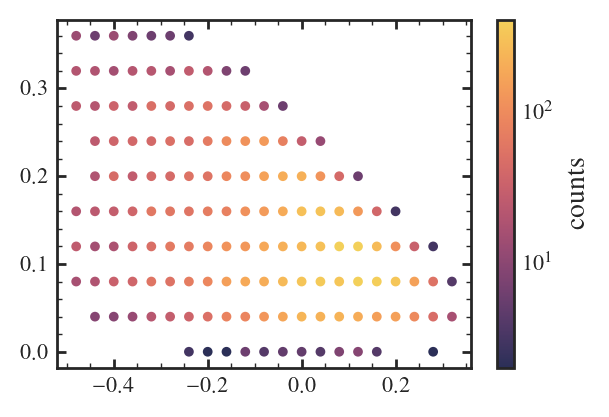

In [15]:
plt.scatter(model._x, model._y, c=model._counts, norm=matplotlib.colors.LogNorm())
plt.colorbar(label = "counts")

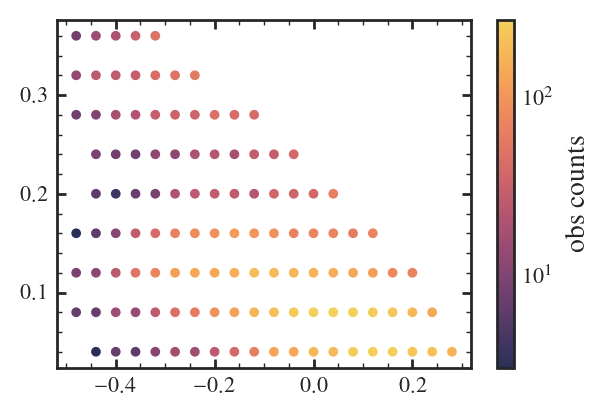

In [15]:
plt.scatter(model._x, model._y, c=model.obs_counts, norm=matplotlib.colors.LogNorm())
plt.colorbar(label = "obs counts")

In [16]:
surp.set_yields()

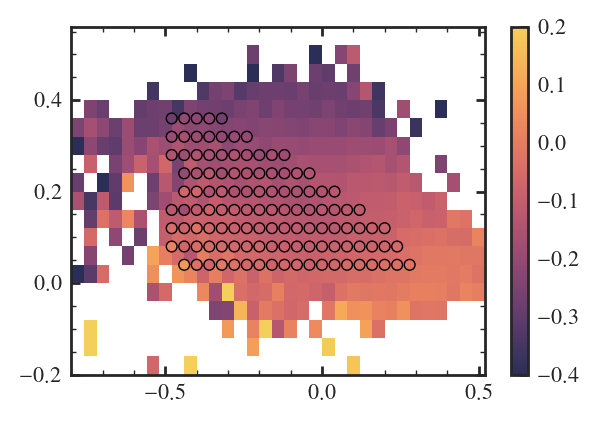

In [18]:
from scipy.stats import binned_statistic_2d
w = 0.04
bins=(np.arange(-0.8, 0.55, w), np.arange(-0.2, 0.6, w))

stat, xedges, yedges, binnumber = binned_statistic_2d(
    surp.subgiants.MG_H, surp.subgiants.MG_FE, surp.subgiants.C_MG, statistic='mean', bins=bins
)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(bins[0], bins[1], stat.T, shading='auto', vmin=-0.4, vmax=0.2)


plt.scatter(model._x, model._y, c=to_brak(model.obs) , vmin=-0.4, vmax=0.2, ec="black", lw=0.5, s=15)

plt.colorbar(pcm)



length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      2.505518
y0_cc      0.986837
zeta_cc    0.895014
dtype: float64


/tmp/ipykernel_916725/1476305734.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1476305734.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1476305734.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean

KeyError: 'obs_sem'

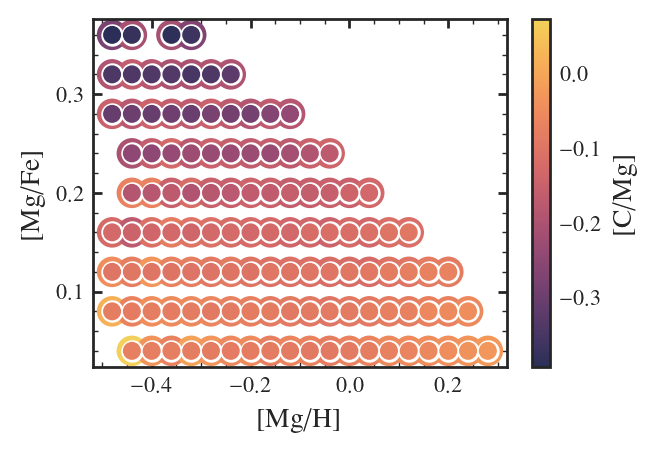

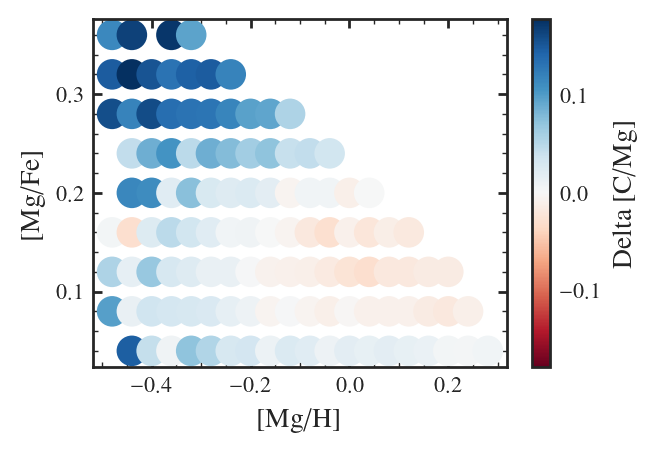

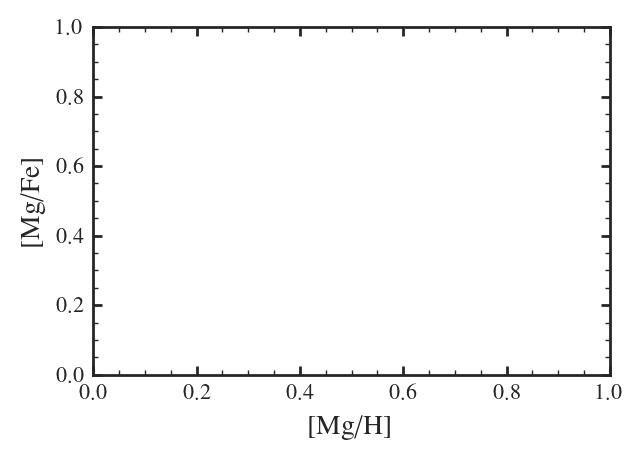

In [47]:
plot_all("../mcmc_models/fiducial")

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.549547
y0_cc      1.512667
zeta_cc    0.717634
dtype: float64
chi2 reduced =  9.947947570857325


/tmp/ipykernel_2256562/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_2256562/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_2256562/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

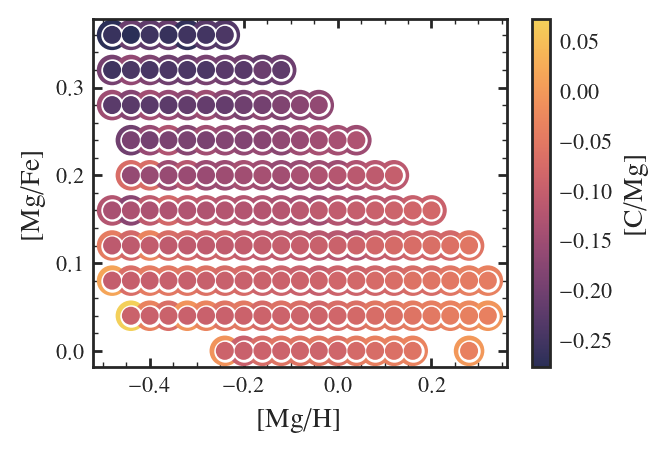

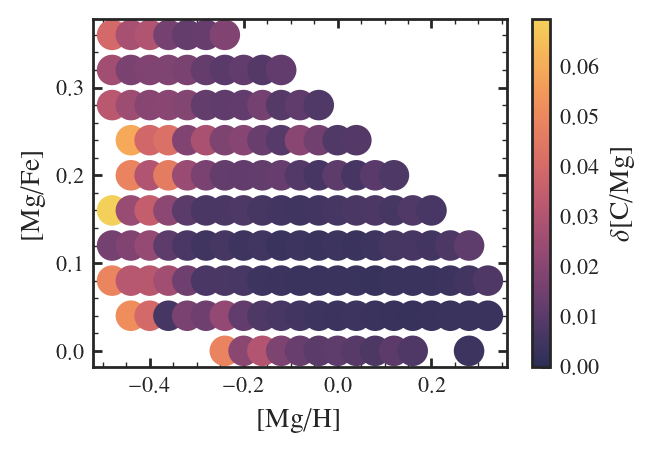

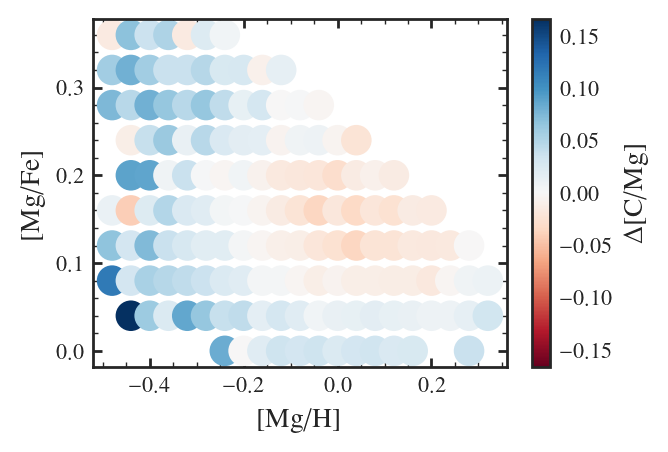

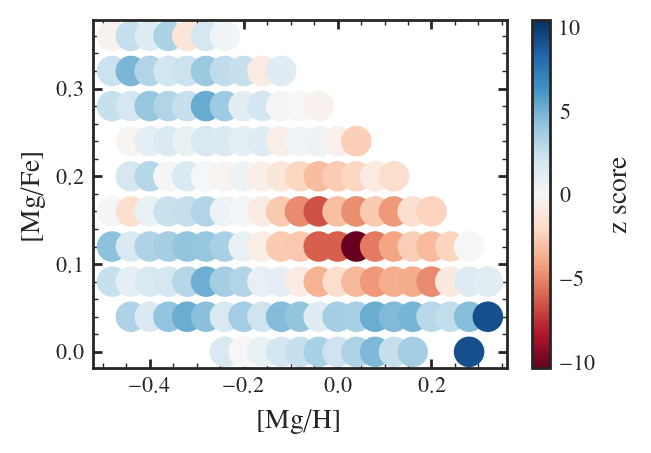

In [16]:
plot_all("fiducial")


adding  spline_0
length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'spline_0': {'name': 'perturbations/spline_0', 'prior': 'Normal', 'prior_args': [0.79, 0.0]}, 'spline_1': {'name': 'perturbations/spline_1', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_2': {'name': 'perturbations/spline_2', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_3': {'name': 'perturbations/spline_3', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_4': {'name': 'perturbations/spline_4', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_5': {'name': 'perturbations/spline_5', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_6': {'name': 'perturbations/spline_6', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_7': {'name': 'perturbations/spline_7', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}}
alpha       1.936769
spline_1    2.103185
spline_2    1.746799
spline_3    1.717946
spline_4    1.695346
spline_5    2.002

/tmp/ipykernel_2256562/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_2256562/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_2256562/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

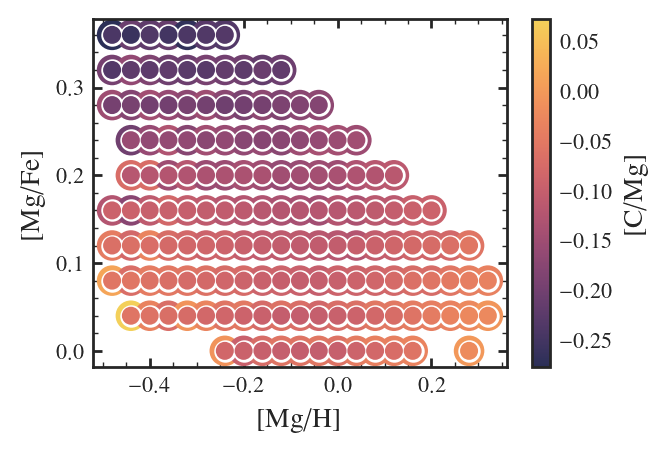

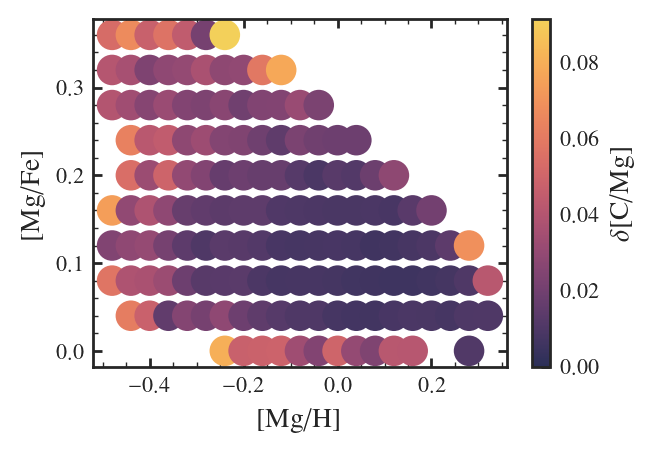

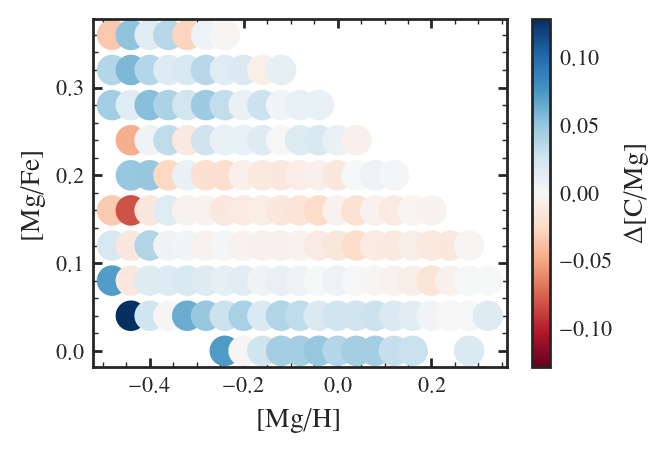

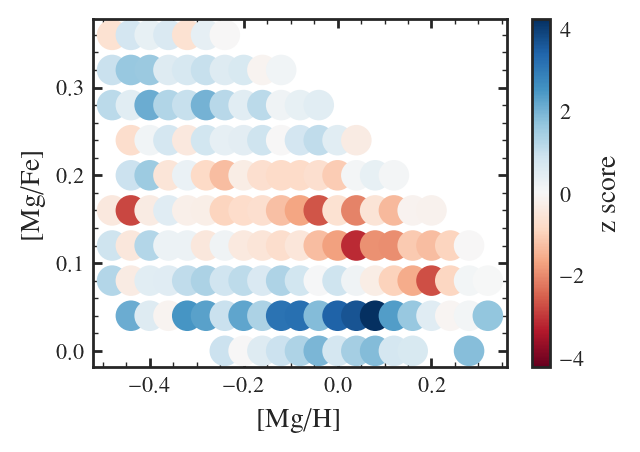

In [17]:
plot_all("fiducial_spline")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.429268
y0_cc      1.625455
zeta_cc    0.626317
dtype: float64
chi2 reduced =  1.4078994391744737


/tmp/ipykernel_916725/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_916725/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, lab

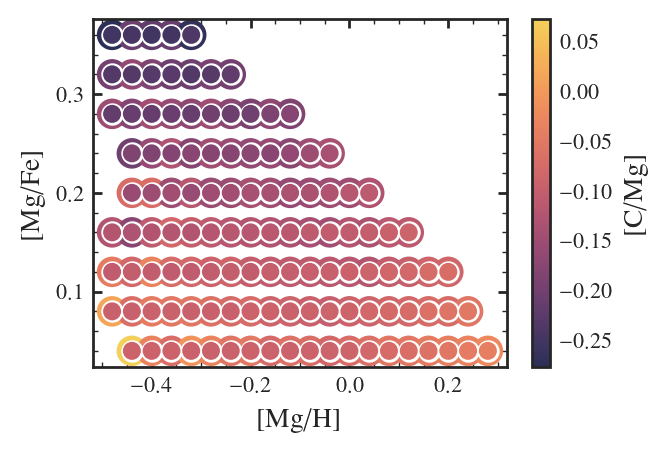

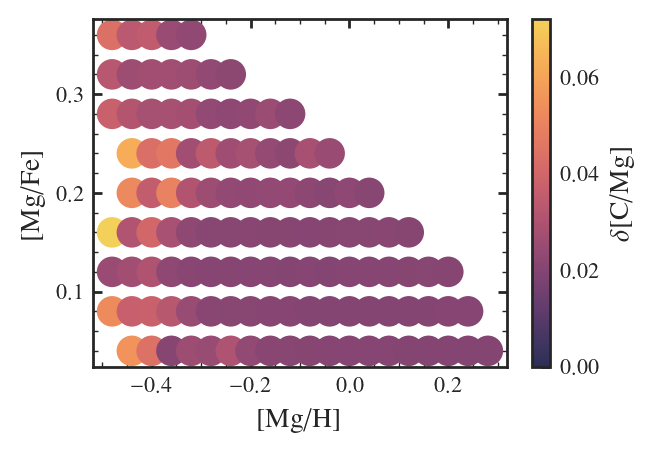

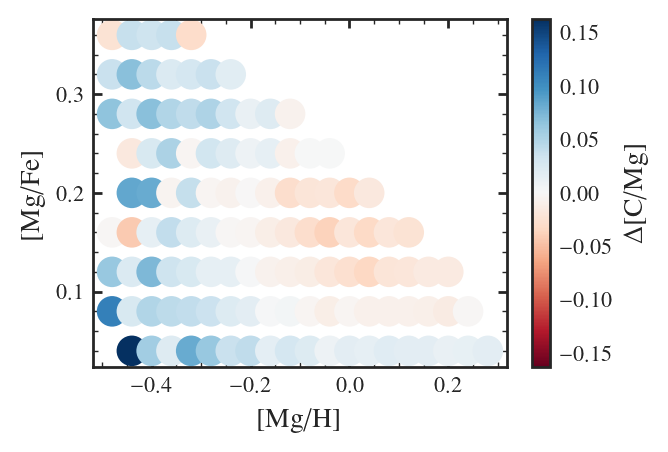

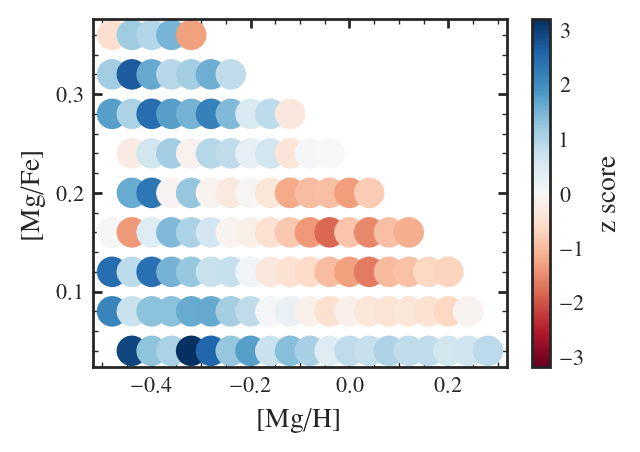

In [102]:
plot_all("fiducial", s_int=0.02)


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.590611
y0_cc      1.750530
zeta_cc    0.403841
dtype: float64
chi2 reduced =  1.0279129875909137


/tmp/ipykernel_916725/876736848.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/876736848.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/876736848.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i

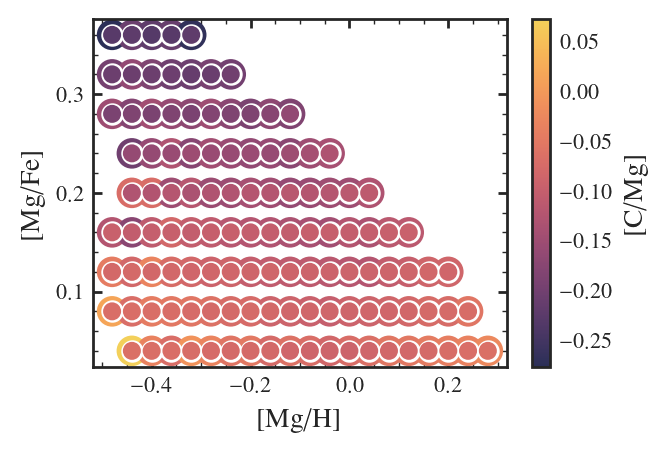

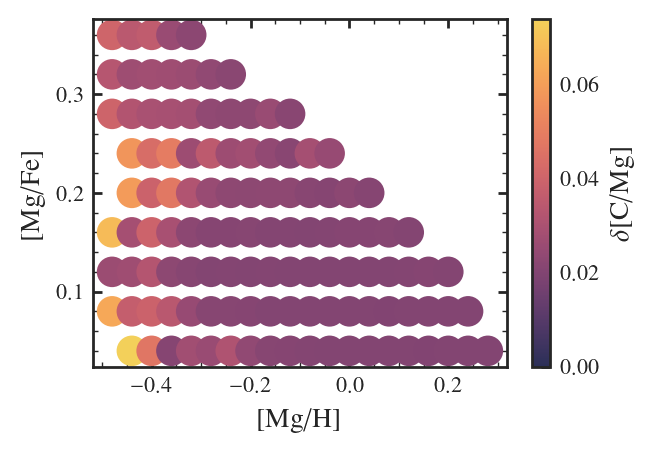

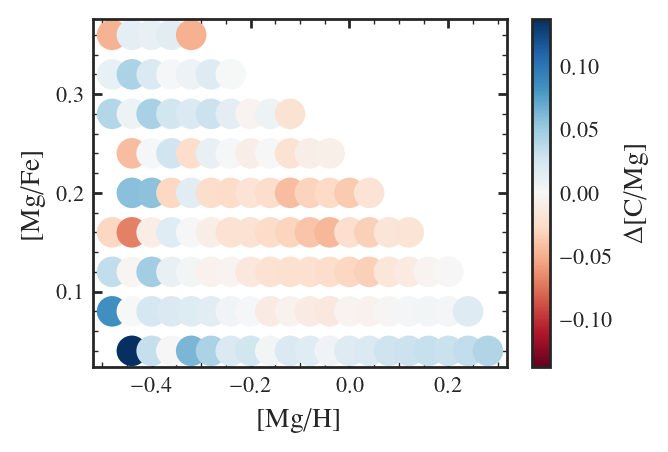

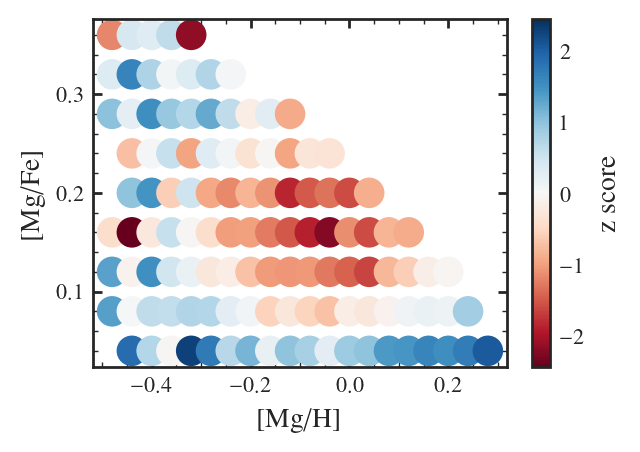

In [76]:
plot_all("fiducial_sigma0.05", s_int=0.02)


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.552545
y0_cc      1.742189
zeta_cc    0.431036
dtype: float64
chi2 reduced =  2.9241531734801085


/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean

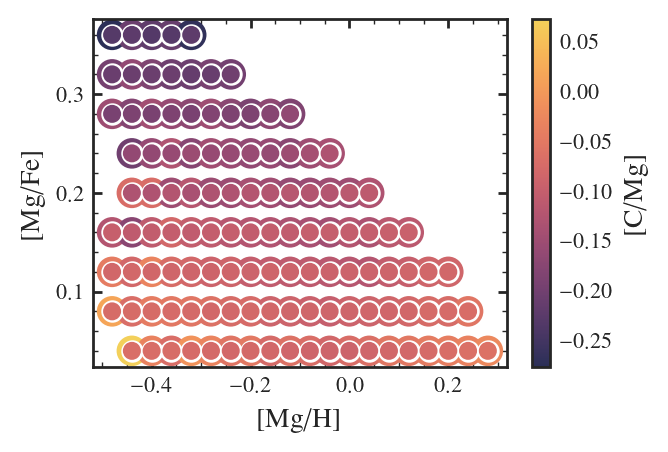

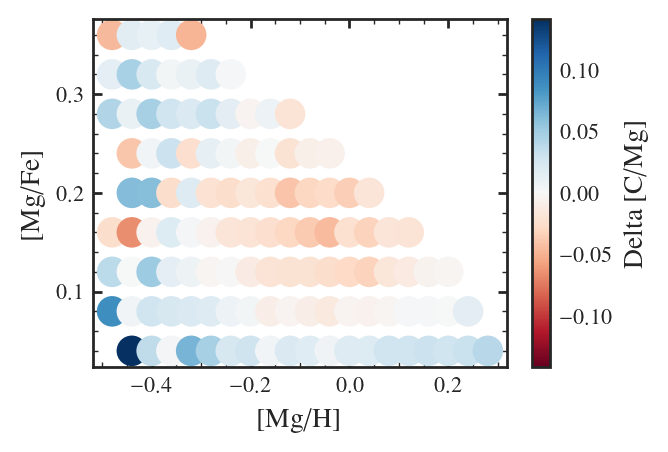

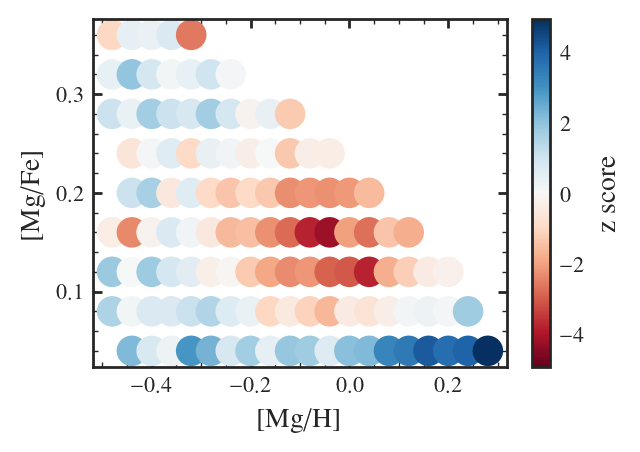

In [27]:
plot_all("fiducial_sigma")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.553625
y0_cc      1.743968
zeta_cc    0.426959
dtype: float64
chi2 reduced =  2.9450034984437887


/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean

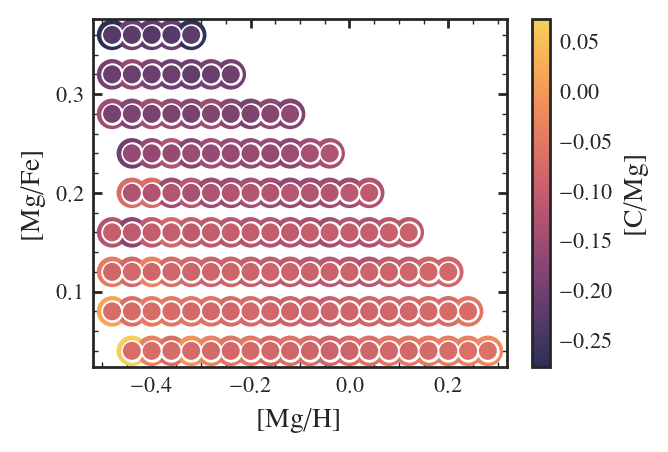

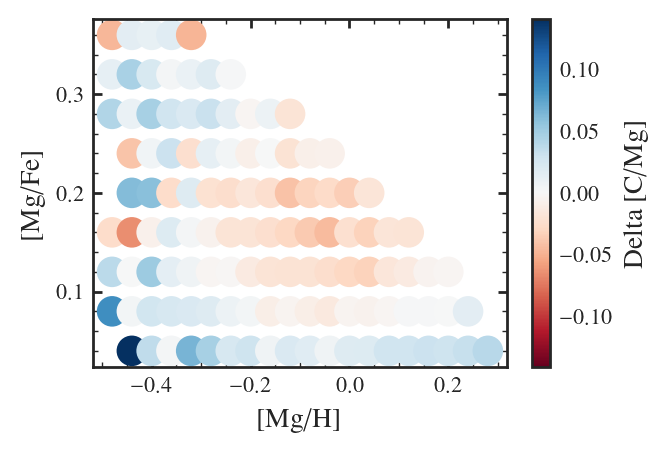

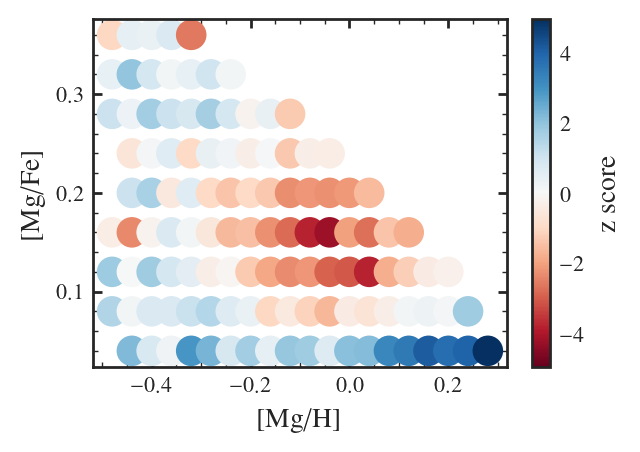

In [33]:
plot_all("fiducial_lin")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      2.637037
y0_cc      0.988684
zeta_cc    0.839300
dtype: float64
chi2 reduced =  14.428942781909619


/tmp/ipykernel_916725/876736848.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/876736848.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/876736848.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i

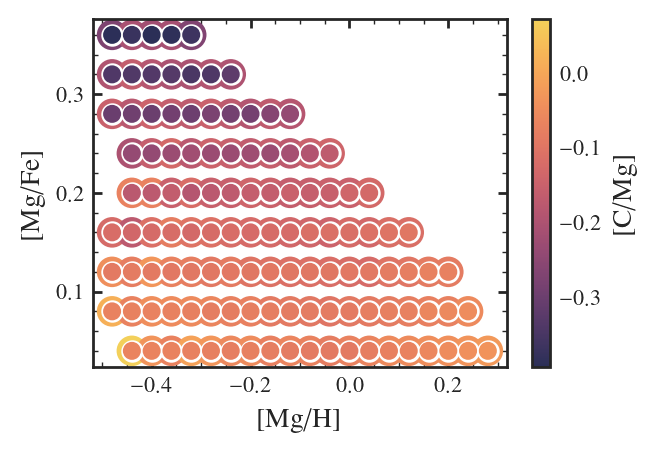

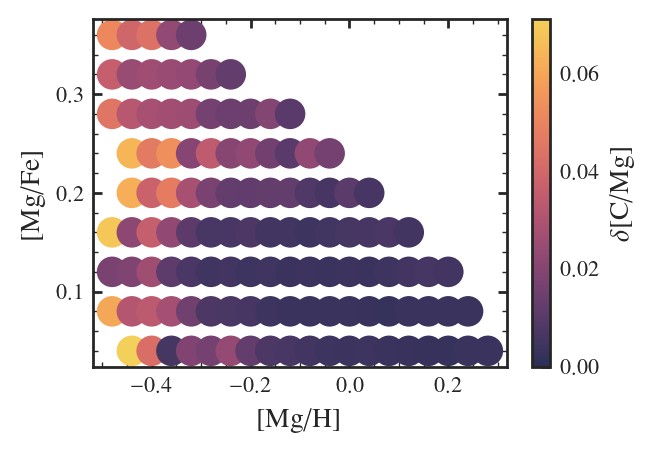

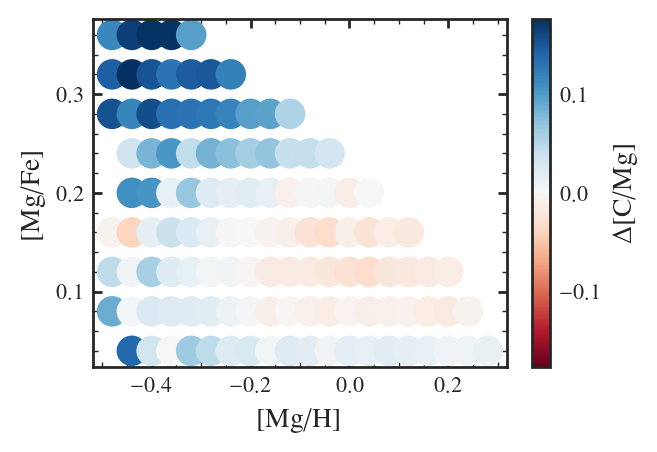

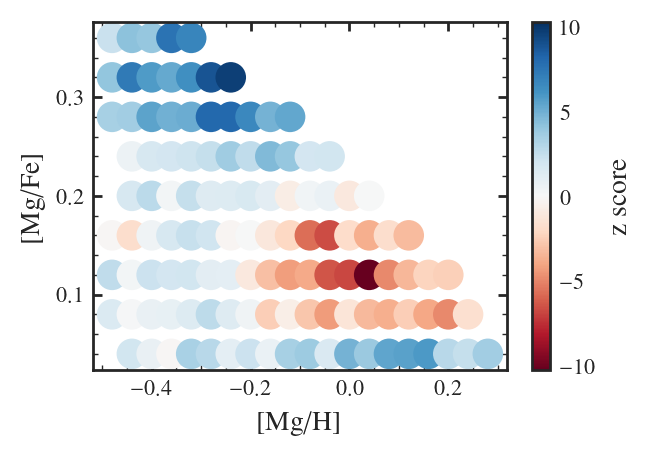

In [71]:
plot_all("fiducial_constrained")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      2.637037
y0_cc      0.988684
zeta_cc    0.839300
dtype: float64
chi2 reduced =  20.12320109765067


/tmp/ipykernel_916725/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_916725/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, lab

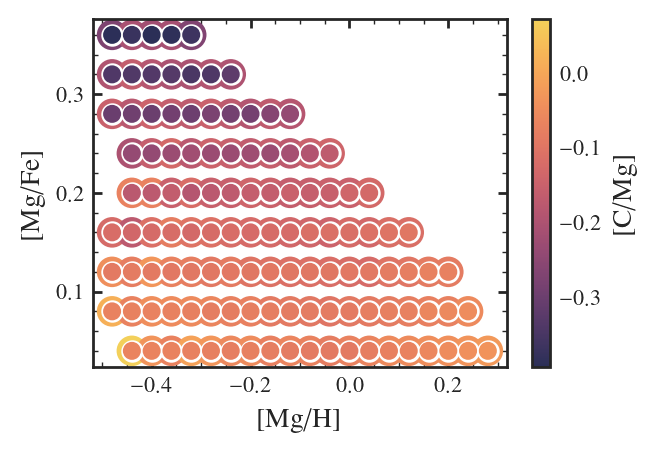

In [ ]:
plot_all("fiducial_constrained")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      3.306319
y0_cc      0.872839
zeta_cc    0.801090
dtype: float64
chi2 reduced =  6.434184495545064


/tmp/ipykernel_916725/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_916725/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, lab

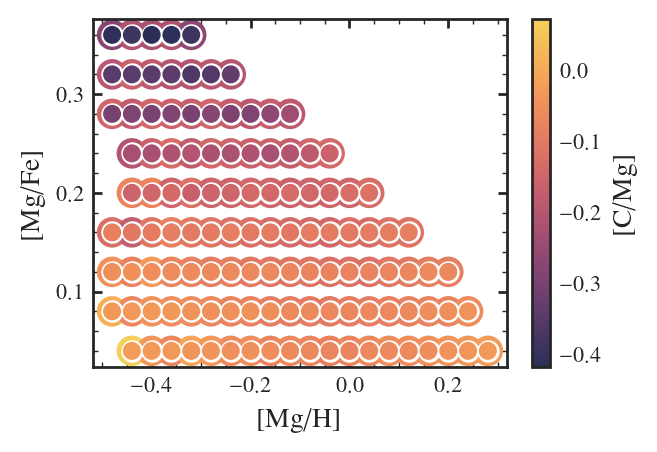

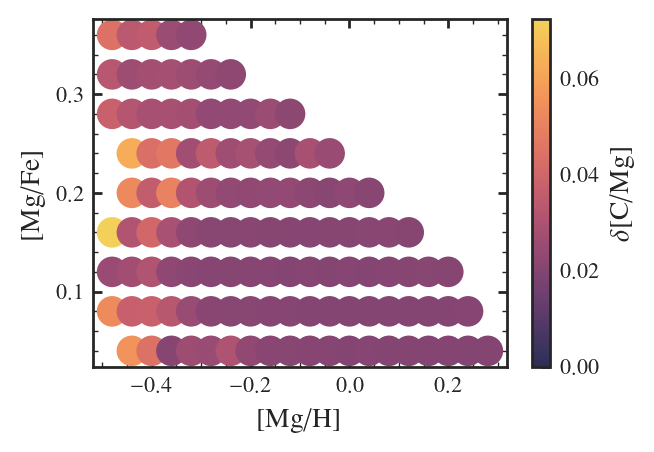

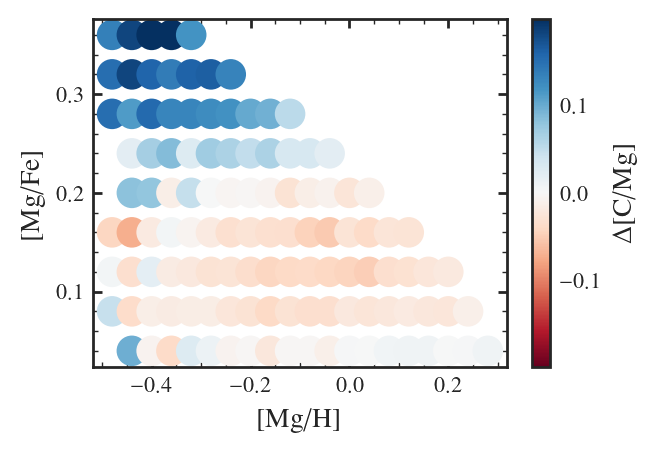

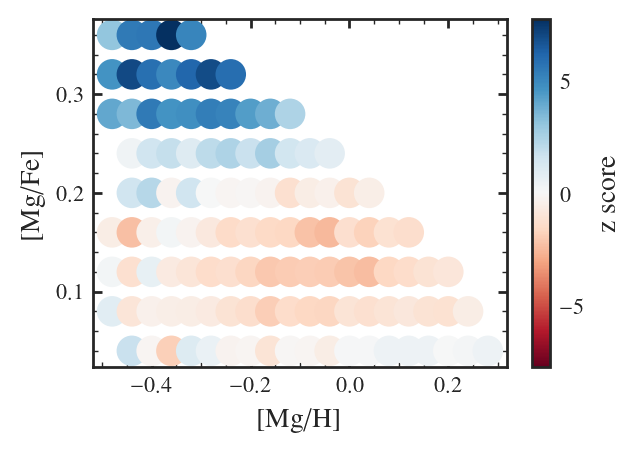

In [104]:
plot_all("fiducial_constrained_sigma0.02", s_int=0.02)


In [36]:
plot_all("fiducial_constrained_lin")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


FileNotFoundError: [Errno 2] No such file or directory: '../../models/mcmc_models_2d/fiducial_constrained_lin/mg_fe_binned.csv'

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity_mf0.7', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.242188
y0_cc      1.945977
zeta_cc    0.377889
dtype: float64
chi2 reduced =  1.0195170614045372


/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1058785/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

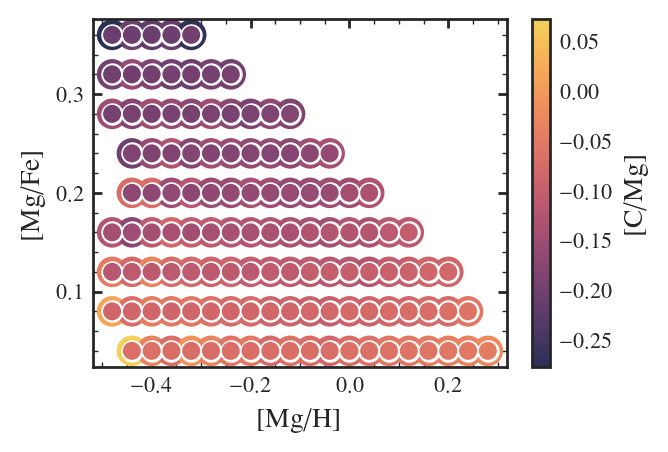

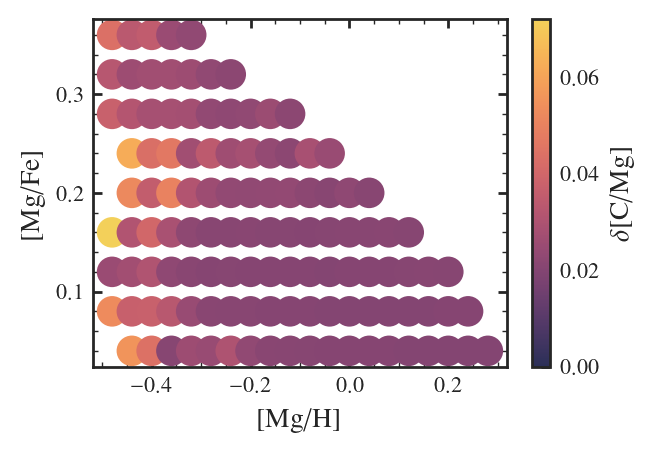

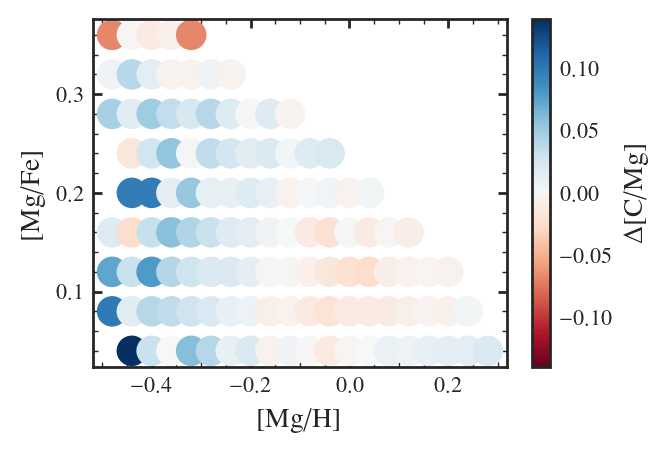

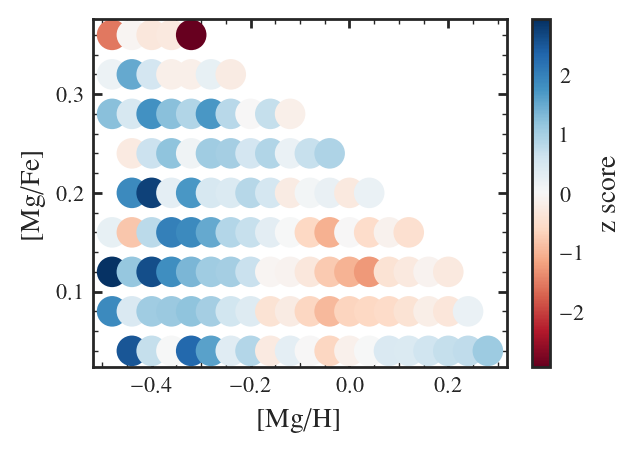

In [17]:
plot_all("fruity_mf0.7", s_int=0.02)


length of samples =  48000
{'alpha': {'name': 'perturbations/aton', 'prior': 'TruncNormal', 'prior_args': [1.0, 1.0, 0.0, inf]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'TruncNormal', 'prior_args': [2.0, 1.0, 0.0, inf]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'TruncNormal', 'prior_args': [0.0, 2.0, 0.0, inf], 'y0': 0.001}}
alpha      0.935011
y0_cc      1.785872
zeta_cc    0.753217
dtype: float64
chi2 reduced =  1.3353237882995082


/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1058785/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

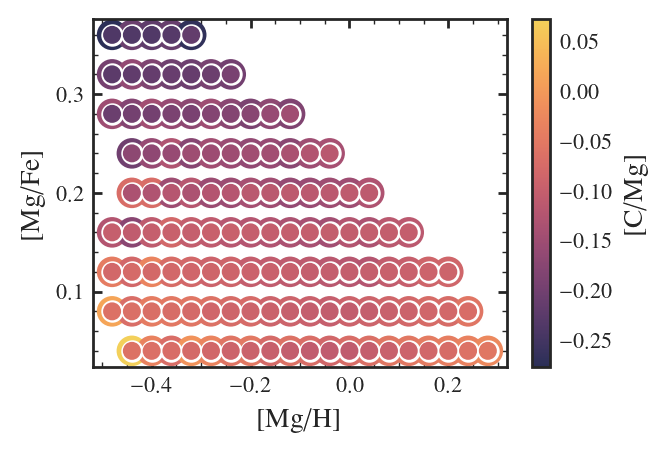

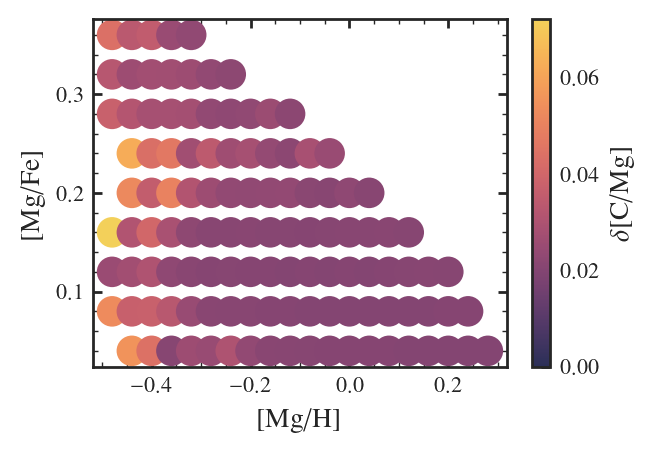

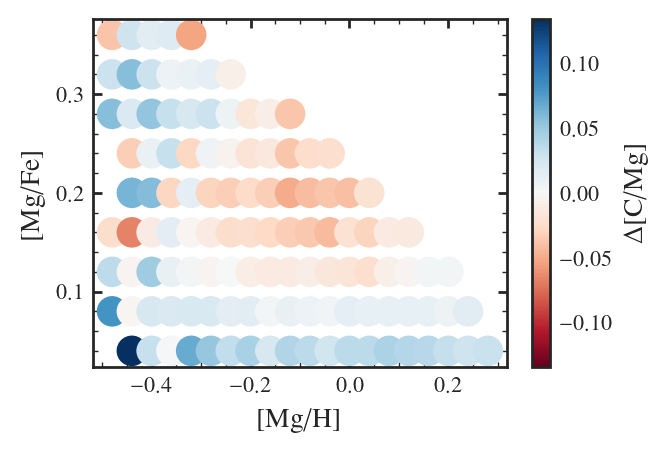

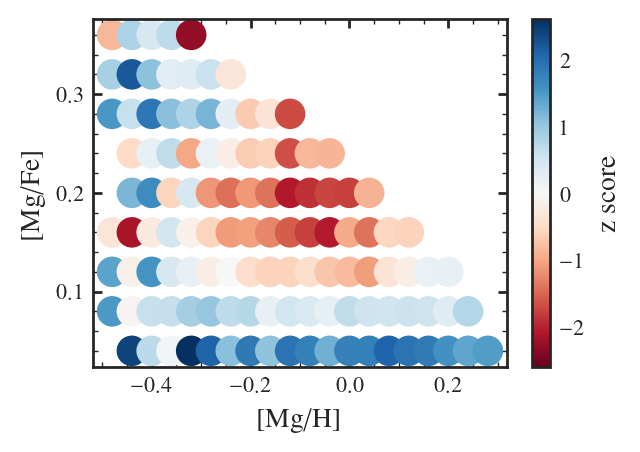

In [18]:
plot_all("aton", s_int=0.02)


length of samples =  48000
{'alpha': {'name': 'perturbations/monash', 'prior': 'TruncNormal', 'prior_args': [1.0, 1.0, 0.0, inf]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'TruncNormal', 'prior_args': [2.0, 1.0, 0.0, inf]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'TruncNormal', 'prior_args': [1.0, 2.0, 0.0, inf], 'y0': 0.001}}
alpha      0.747653
y0_cc      1.538942
zeta_cc    0.789947
dtype: float64
chi2 reduced =  3.424346148435806


/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1058785/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

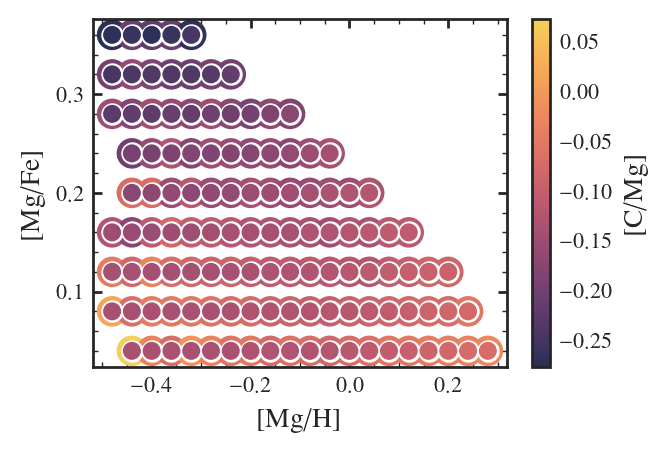

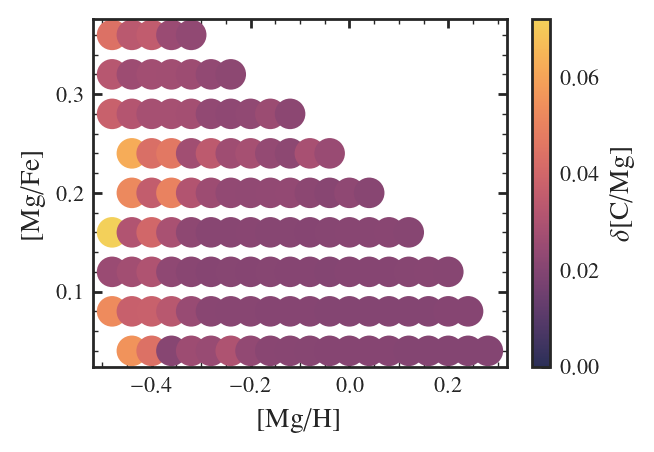

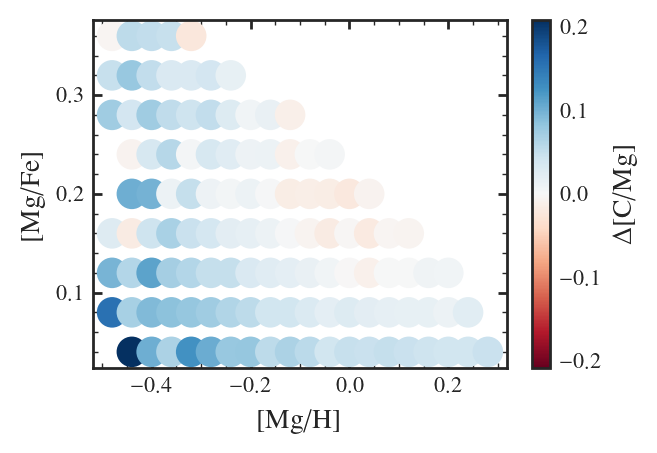

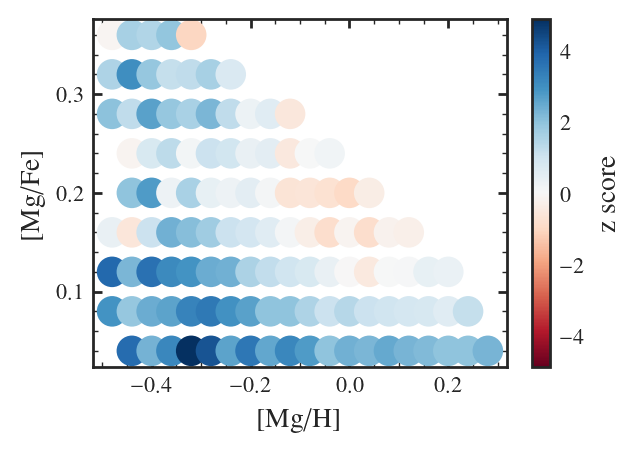

In [19]:
plot_all("monash", s_int=0.02)


length of samples =  48000
{'alpha': {'name': 'perturbations/nugrid', 'prior': 'TruncNormal', 'prior_args': [1.0, 1.0, 0.0, inf]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'TruncNormal', 'prior_args': [2.0, 1.0, 0.0, inf]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'TruncNormal', 'prior_args': [1.0, 2.0, 0.0, inf], 'y0': 0.001}}
alpha      0.997385
y0_cc      2.293768
zeta_cc    0.474051
dtype: float64


/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1058785/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1058785/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

chi2 reduced =  3.2326069009016134


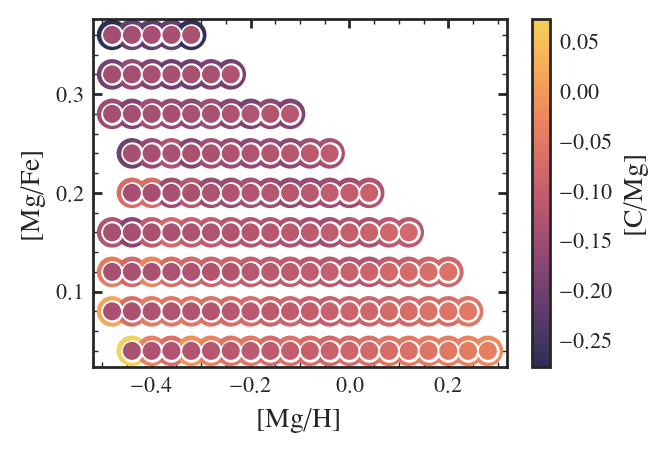

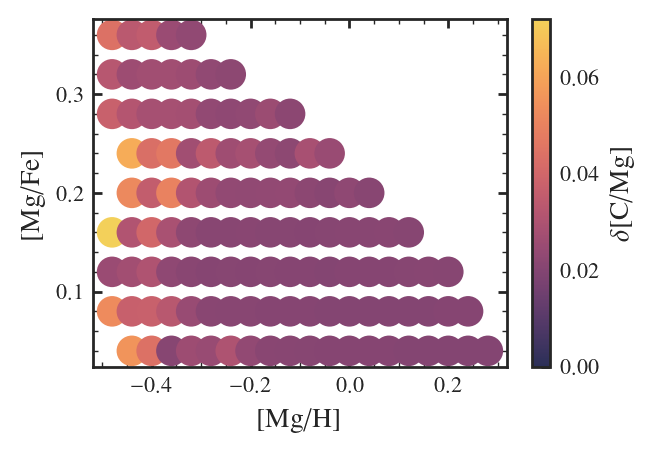

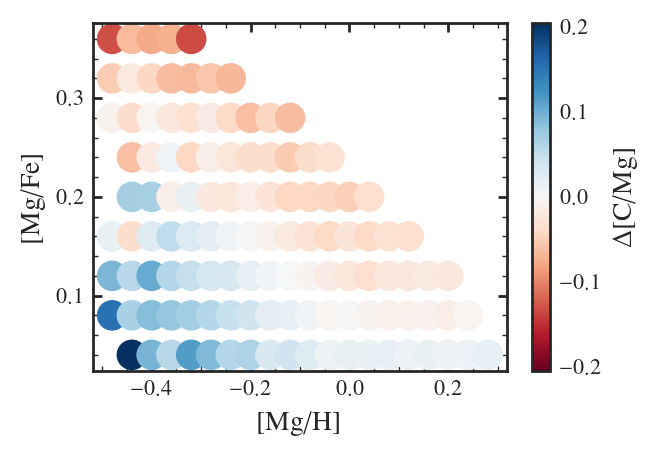

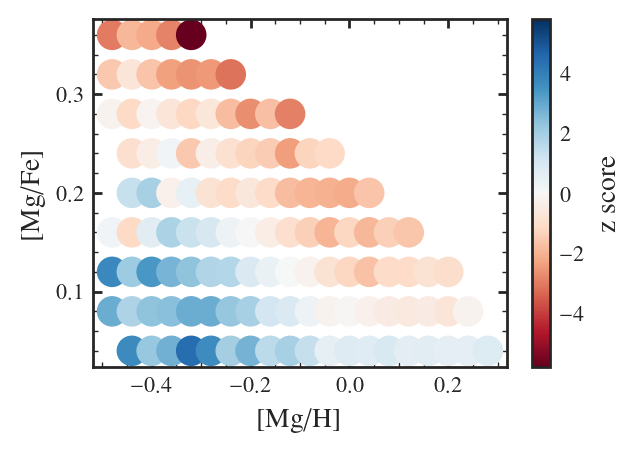

In [20]:
plot_all("nugrid", s_int=0.02)


length of samples =  48000
{'datafile': '../fiducial/run/stars.csv', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      2.495462
y0_cc      1.072236
zeta_cc    0.817174
dtype: float64
chi2 reduced =  1.8388080335400574


/tmp/ipykernel_1218391/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1218391/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1218391/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

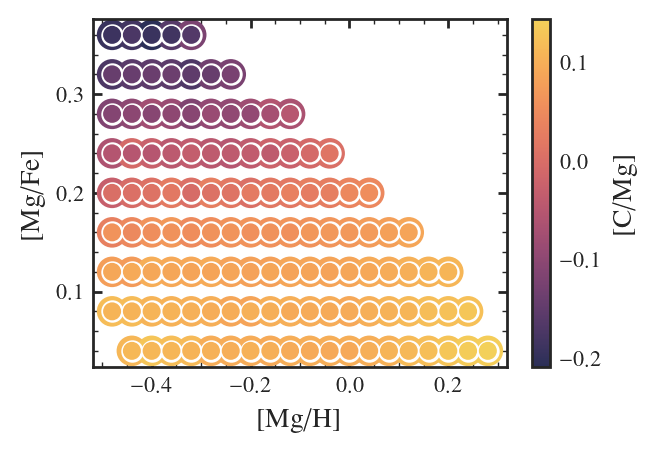

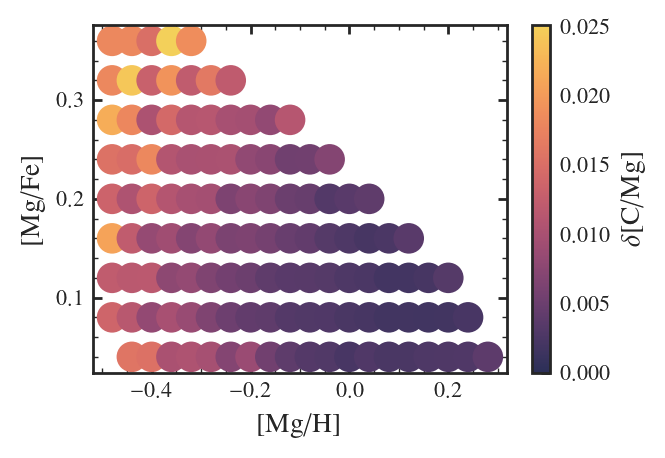

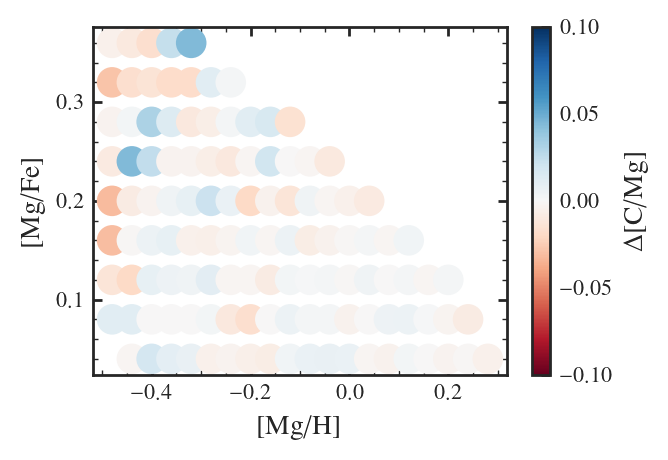

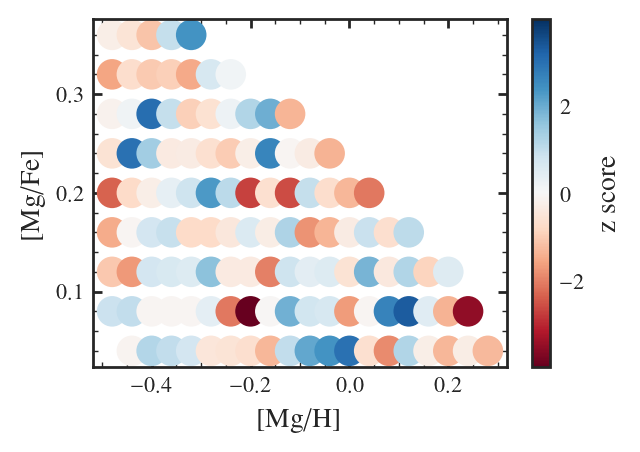

In [15]:
plot_all("fiducial_recovery")


length of samples =  48000
{'alpha': {'name': 'multi_perturbations/lateburst', 'C_MG': 'AG_MG', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'multi_perturbations/lateburst', 'C_MG': 'CD_MG', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'multi_perturbations/lateburst', 'C_MG': 'IN_MG', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}
alpha      1.889576
y0_cc      1.455825
zeta_cc    0.648768
dtype: float64


/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1975075/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

chi2 reduced =  9.606172964442136


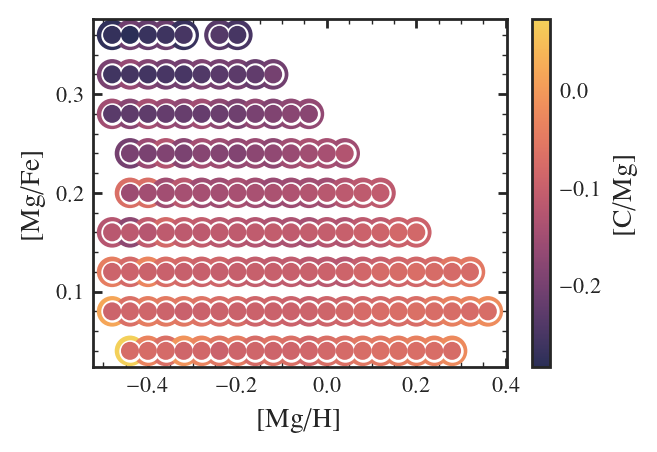

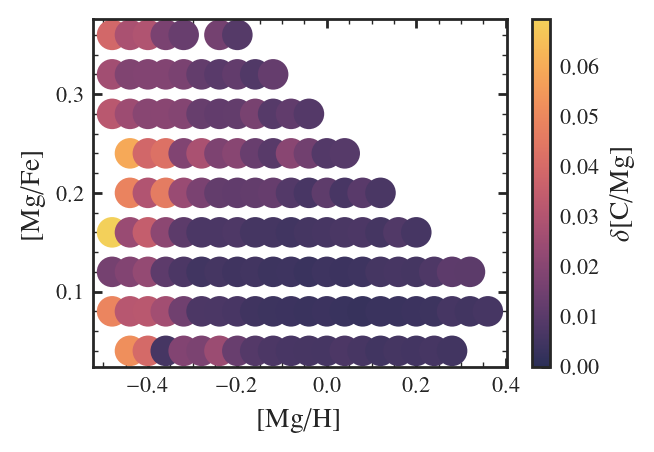

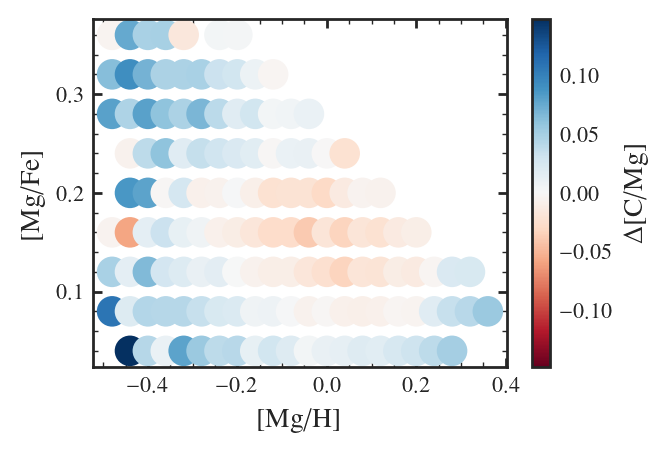

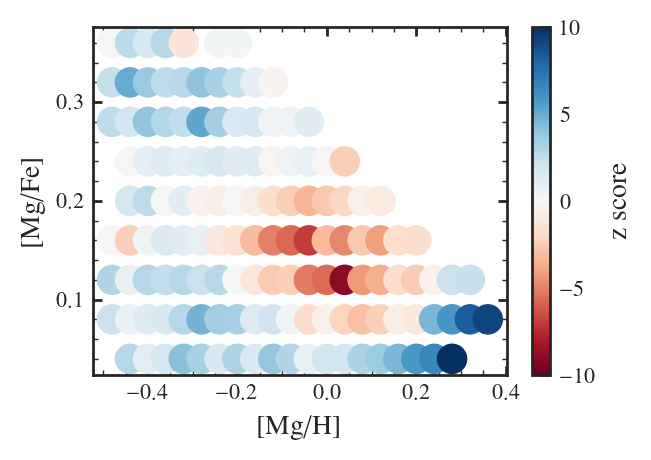

In [14]:
plot_all("lateburst")


length of samples =  48000
{'alpha': {'name': 'multi_perturbations/eta2', 'C_MG': 'AG_MG', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'multi_perturbations/eta2', 'C_MG': 'CD_MG', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'multi_perturbations/eta2', 'C_MG': 'IN_MG', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}
alpha      1.521591
y0_cc      1.534841
zeta_cc    0.700688
dtype: float64
chi2 reduced =  9.5795339835226


/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1975075/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

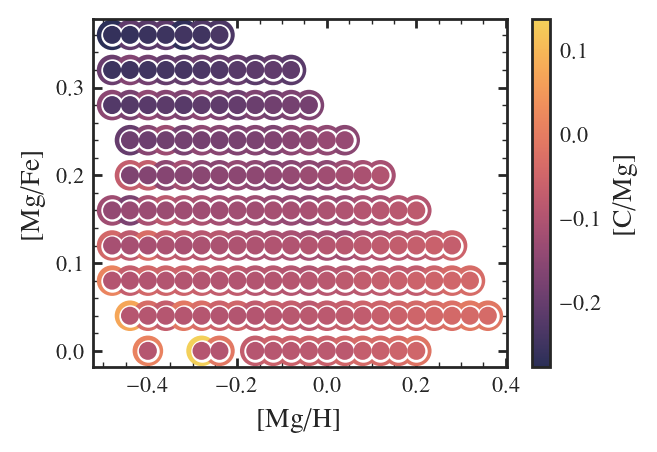

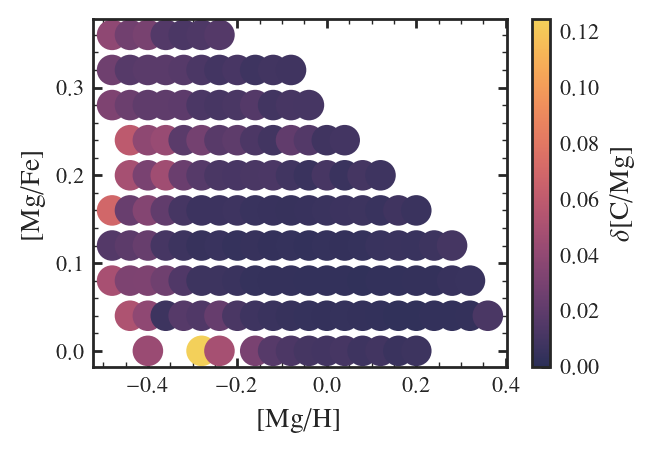

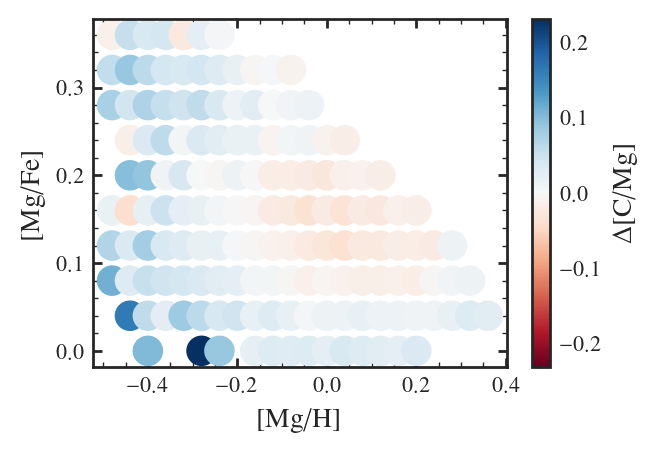

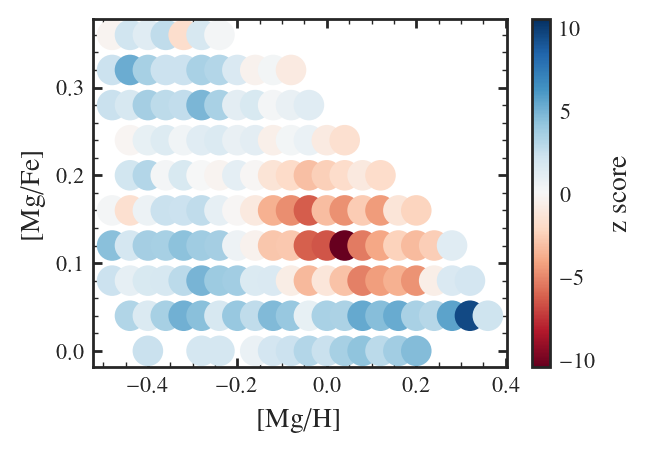

In [18]:
plot_all("eta2")


length of samples =  48000
{'alpha': {'name': 'multi_perturbations/twoinfall', 'C_MG': 'AG_MG', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'multi_perturbations/twoinfall', 'C_MG': 'CD_MG', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'multi_perturbations/twoinfall', 'C_MG': 'IN_MG', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}
alpha      1.539516
y0_cc      1.553565
zeta_cc    0.692104
dtype: float64
chi2 reduced =  8.802105441369623


/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1975075/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

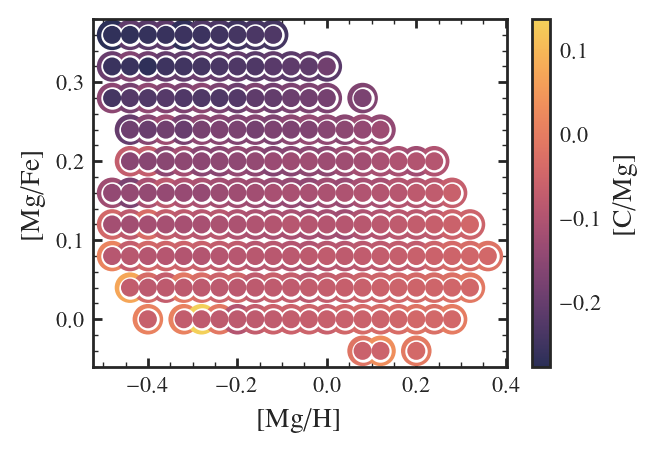

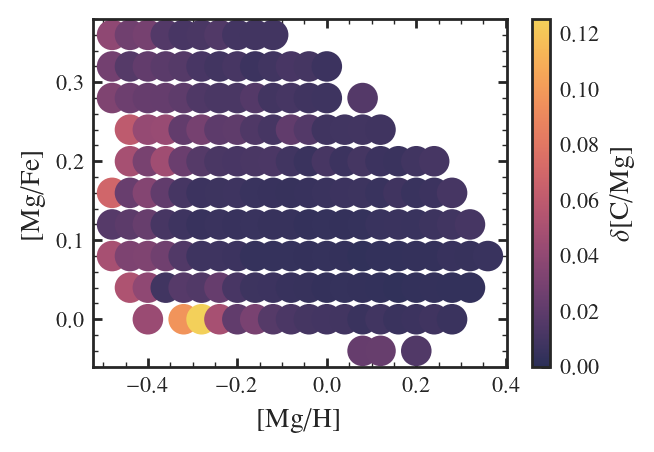

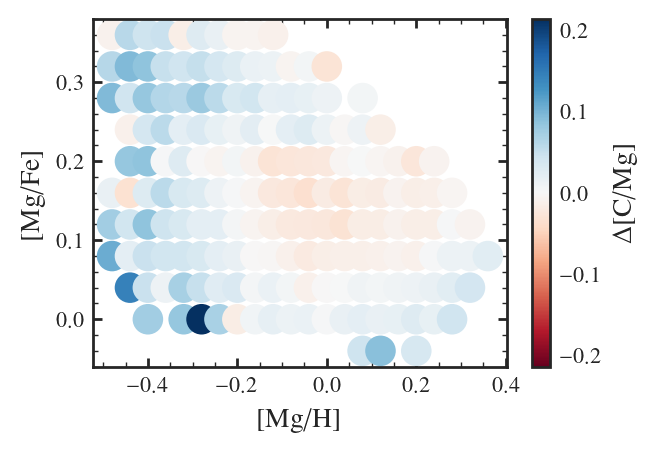

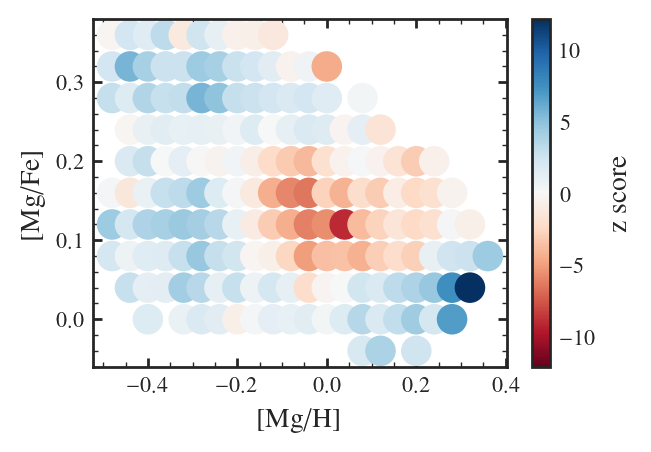

In [19]:
plot_all("twoinfall")


adding  y0_cc
length of samples =  48000
{'datafile': 'vincenzo+2021', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}
alpha      4.676964
zeta_cc    1.470019
dtype: float64
chi2 reduced =  135.5113110318491


/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1975075/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

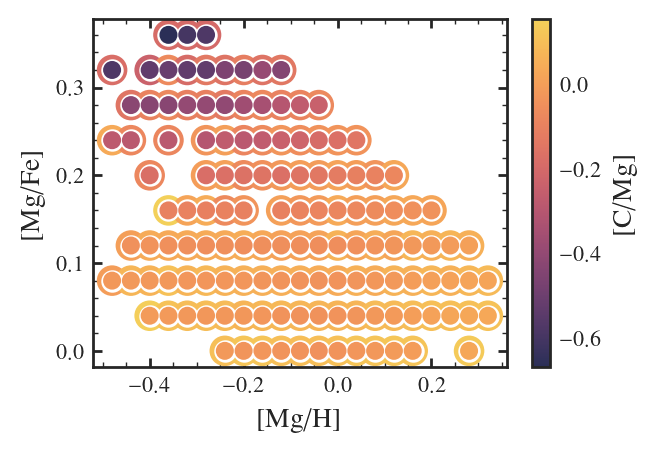

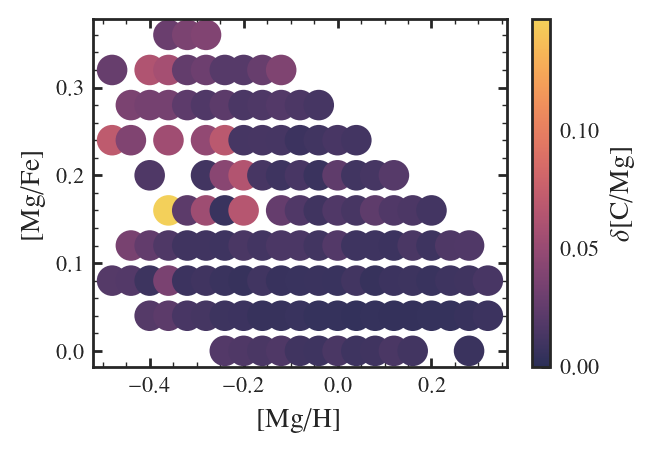

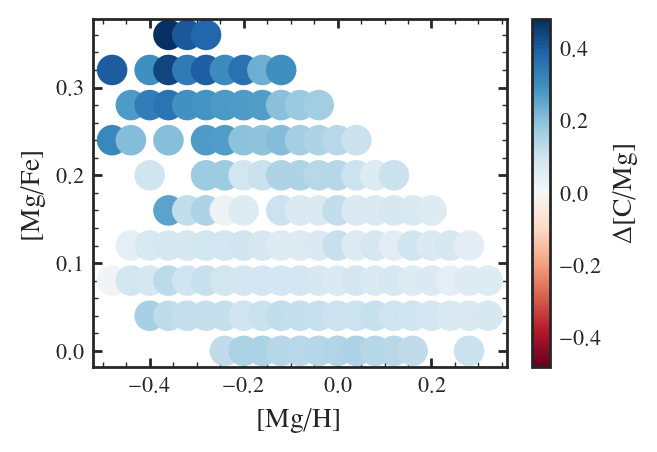

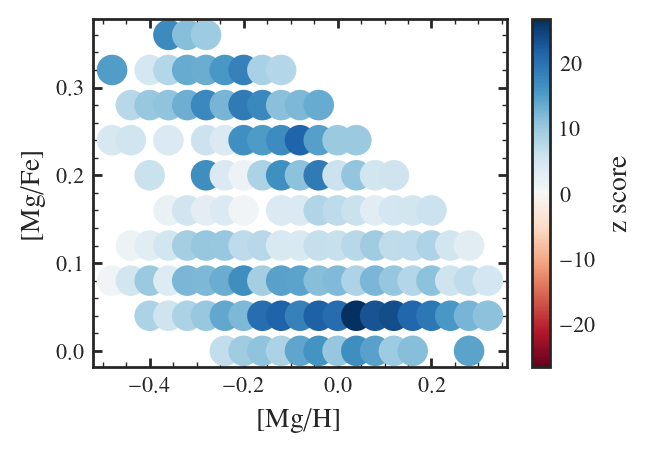

In [15]:
plot_all("fiducial_vincenzo")


adding  y0_cc
length of samples =  48000
{'datafile': '~/surp/carbon_paper/data_analysis/galah_dwarfs.csv', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}
alpha      4.939745
zeta_cc    0.623447
dtype: float64
chi2 reduced =  425.7823073796893


/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_1975075/585895329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
/tmp/ipykernel_1975075/585895329.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, 

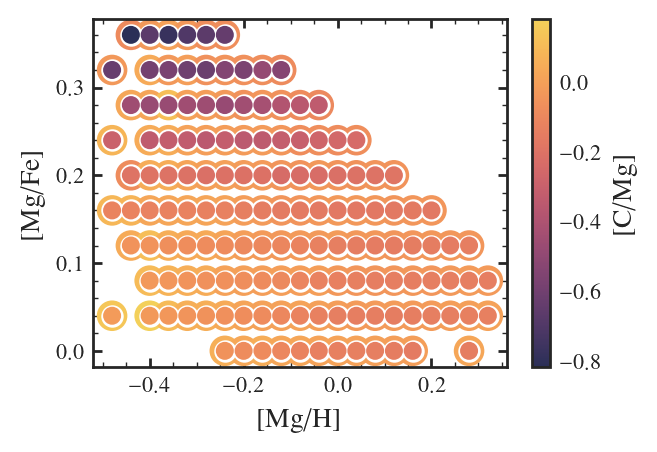

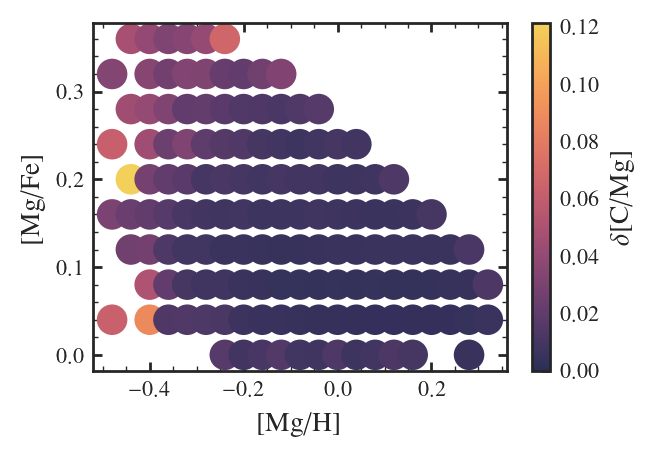

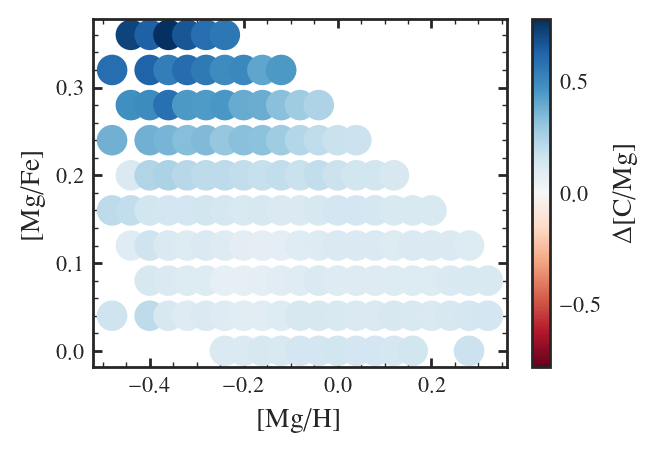

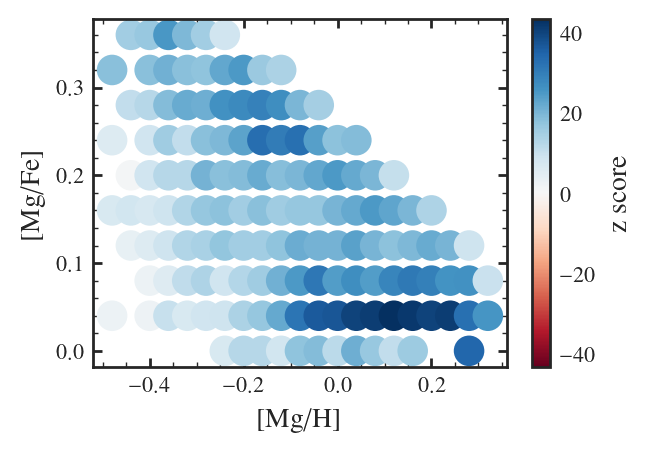

In [17]:
plot_all("fiducial_galah_constrained")
